# 04 Model Training and Evaluation

Train a simple LightGBM model to forecast the next-month Saudi production and evaluate its performance using a time-series split.

In [17]:
# Imports and path setup
import sys
from pathlib import Path
project_root = Path('/home/sayda/update')
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
from src.config import PROCESSED_DATA_DIR

In [18]:
# Load features
df = pd.read_csv(PROCESSED_DATA_DIR / "features.csv", parse_dates=["date"])
target = "saudi_production"
feature_cols = [c for c in df.columns if c not in {"date", target} and not c.startswith(target)]

In [19]:
# Prepare data for horizon 1 (shift target)
df["target_h1"] = df[target].shift(-1)
df.dropna(inplace=True)
X = df[feature_cols]
y = df["target_h1"]

In [20]:
# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=3)
rmses, maes = [], []
for train_idx, val_idx in tscv.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=6)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmses.append(np.sqrt(mean_squared_error(y_val, preds)))
    maes.append(mean_absolute_error(y_val, preds))

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 36, number of used features: 0
[LightGBM] [Info] Start training from score 2011.083333
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

In [21]:
# Cross-validation metrics
print("Average RMSE:", np.mean(rmses))
print("Average MAE:", np.mean(maes))

Average RMSE: 2.875618864974532
Average MAE: 2.741600628868081


In [22]:
# Fit on all data
model_final = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=6)
model_final.fit(X, y)
importances = model_final.feature_importances_
indices = np.argsort(importances)[-10:][::-1]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1116
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 47
[LightGBM] [Info] Start training from score 2015.583333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

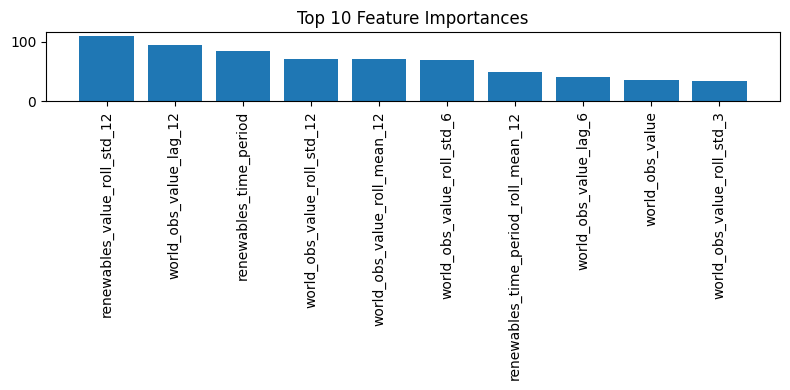

In [23]:
# Plot top 10 feature importances
plt.figure(figsize=(8,4))
plt.bar(range(len(indices)), importances[indices], tick_label=[feature_cols[i] for i in indices])
plt.xticks(rotation=90)
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()